In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples, get_lr_loss
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from sklearn.manifold import TSNE
import numpy as np
import torch

In [2]:
## Device toggle
device = torch.device("mps")
# device = torch.device("cpu")

In [3]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
vocab_size = len(vocab) + 1 # Blank token
block_length = max_length + 1
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [4]:
# ## Hyperparameters
emb_dim = 64
head_size = 128
dropout = 0.2

In [5]:
class Head(nn.Module):
    def __init__(self, emb_dim, head_size):
        super().__init__()
        self.key = nn.Linear(emb_dim, head_size, bias=False)
        self.query = nn.Linear(emb_dim, head_size, bias=False)
        self.value = nn.Linear(emb_dim, head_size, bias=False)
        # Define a register buffer
        self.register_buffer('tril', torch.tril(torch.ones(block_length,block_length)))
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        ## Initialize the vector
        k = self.key(x) # B,T,head_size
        q = self.query(x) # B,T,head_size
        v = self.value(x) # B,T,head_size
        wei = k @ torch.transpose(q, 1, 2) * C**-0.5 # B,T,head_size * B,head_size,T -> B,T,T
        wei = torch.masked_fill(wei, self.tril[:T,:T] == 0, float('-Inf')) # Only selecting till the Tth column will be esp important during generation o/w will expect maxx_length columns at everytime step and throw an error
        wei = self.dropout(F.softmax(wei, dim=-1)) # B,T,T
        # print(k.shape, q.shape, v.shape, wei.shape)
        out = wei @ v #B,T,T * B,T,H -> B,T,H i.e. 32,16,16 * 32,16,8 -> 32,16,8
        return out

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, num_heads, emb_dim):
        super().__init__()
        self.heads = nn.ModuleList([Head(emb_dim, head_size) for i in range(num_heads)]) # B,T,head_size*num_heads
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        x = self.proj(x)
        x = self.dropout(x)
        return x

In [7]:
class Feedforward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim),
            nn.ReLU(),
            nn.Linear(4*emb_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        return self.ff(x)

In [8]:
class Block(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.head_size = emb_dim // num_heads
        self.sa_head = MultiHeadAttention(self.head_size, num_heads, emb_dim)
        self.ff = Feedforward(emb_dim)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x, targets=None):
        x = x + self.sa_head(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

In [9]:
class Xformer(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size + 1, emb_dim)
        self.pos_embedding = nn.Embedding(vocab_size + 1, emb_dim)
        # self.sa_head = MultiHeadAttention(emb_dim//4, 4, emb_dim, block_length)
        # self.ff = Feedforward(emb_dim)
        self.blocks = nn.Sequential(
            Block(emb_dim, num_heads=4), 
            Block(emb_dim, num_heads=4),
            Block(emb_dim, num_heads=4),
            nn.LayerNorm(emb_dim)
        )
        self.lm_head = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, targets=None):
        tok_emb = self.token_embedding(x)
        pos_emb = self.pos_embedding(x)
        x = tok_emb + pos_emb # B, T, emb_dim
        # x = self.sa_head(x) # B, T, head_size
        # x =  self.ff(x)
        x = self.blocks(x)
        logits = self.lm_head(x) # B, T, vocab_size

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return(logits,loss)

In [10]:
# # Test run on a batch size of 1 for debug
# batch_size = 1
# train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# model = Xformer(emb_dim, head_size).to(device)
# optimizer = Adam(model.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss()
# xb, yb = next(iter(train_dataloader))
# xb = xb.to(device)
# yb = yb.to(device)
# # print(xb.shape, yb.shape)
# logits, loss = model(xb,yb)
# print(loss)

In [11]:
# Set up optimizer and model
batch_size = 512
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Xformer(emb_dim, head_size).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)
yb = yb.to(device)
logits, loss = model(xb,yb)
print(loss)

tensor(3.4788, device='mps:0', grad_fn=<NllLossBackward0>)


In [13]:
# ## Optimal lr sweep
# import matplotlib.pyplot as plt
# lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, batch_size, 500, -2, -1.5)
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

In [14]:
# Training loop - Initialized in separate loop so that it can be re run without reinitialization that will wipe things out
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

In [15]:
# Training loop 
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 1000
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, test_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    te_loss.append(te_lossi)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

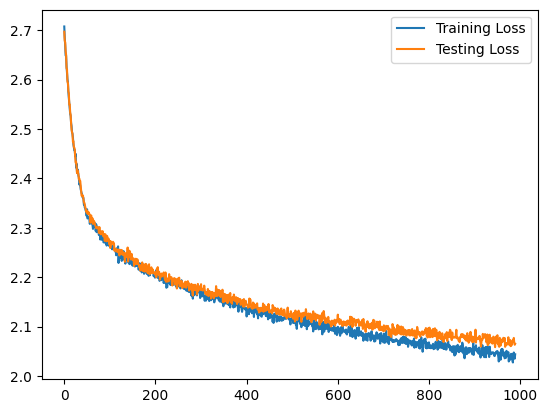

training loss:  2.0465
validation loss:  2.0722


In [19]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss[10:], label='Training Loss')
plt.plot(te_loss[10:], label='Testing Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-100:]))).item(),4))

In [20]:
## Pretty print the samples
print_samples(model, train_data, max_length, device, num=32)

hariellli
re
broxtl
andvisha
ksamari
rochenn
maziel
messete
chaylen
ridoston
finding
bredwis
reiyan
kendyah
ler
irutly
orefi
kamsheyn
cairie
abri
baylyne
mauracja
emdin
josymi
thiam
khyri
shaneya
jakwa
kramina
osana
mon
ollono


['stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'blank']


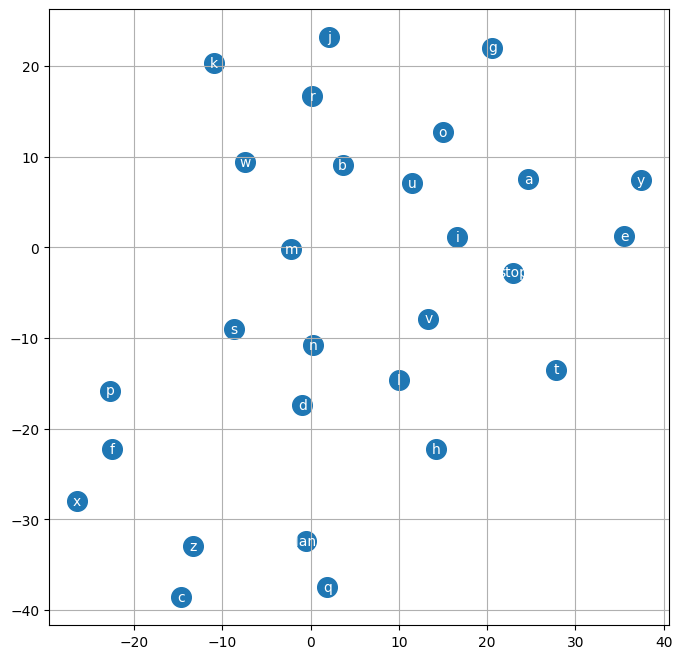

In [21]:
## Plot tsne or pca for embeddings
# t-SNE example:
embeddings_matrix = model.token_embedding.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, perplexity=7)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# Create vectors for ticklabels
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
ticklabels.insert(27,'blank')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')